### Displayport-size-tuning experiment, bug 1251052

In [2]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client, get_clients_history

%pylab inline

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


Let's fetch 10% of Telemetry submissions for the build-ids around the experiment period...

In [3]:
pings = get_pings(sc, app="Firefox", channel="nightly", build_id=("20160301000000", "20160318999999"), fraction=0.5)

... and extract only the attributes we need from the Telemetry submissions:

In [4]:
subset = get_pings_properties(pings, ["environment/addons/activeExperiment",
                                      "environment/system/os/name",
                                      "payload/histograms/CHECKERBOARD_SEVERITY",
                                      "payload/histograms/CHECKERBOARD_DURATION",
                                      "payload/histograms/CHECKERBOARD_POTENTIAL_DURATION",
                                      "payload/histograms/CHECKERBOARD_PEAK"])

Let's filter out submissions that aren't in the experiment:

In [5]:
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment") != {})
subset = subset.filter(lambda p: p.get("environment/addons/activeExperiment")["id"] == u'displayport-tuning-nightly@experiments.mozilla.org')
valid = subset.filter(lambda p: "branch" in p.get("environment/addons/activeExperiment"))
valid = valid.cache()

(For debugging) Inspect a random one just to make sure it looks sane:

In [6]:
# valid.take(1)

How many pings are we looking at?

In [7]:
valid.count()

38907

Let's split out the different histograms, and group them by the experiment branch:

In [8]:
hist_duration = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_DURATION"])).groupByKey().collectAsMap()
hist_peak = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_PEAK"])).groupByKey().collectAsMap()
hist_potential_duration = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_POTENTIAL_DURATION"])).groupByKey().collectAsMap()
hist_severity = valid.map(lambda p: (p["environment/addons/activeExperiment"]["branch"], p["payload/histograms/CHECKERBOARD_SEVERITY"])).groupByKey().collectAsMap()

(Sanity check) Make sure we have a bunch of samples, and comparable numbers in each branch:

In [9]:
{x: len(list(y)) for x, y in hist_duration.items()}

{u'control': 6012,
 u'group2': 6580,
 u'group3': 6643,
 u'group4': 6525,
 u'group5': 6519,
 u'group6': 6628}

Aggregate the histograms over all submissions, for each branch of the experiment:

In [10]:
def aggregate_arrays(xs, ys):
    if xs is None:
        return ys
    
    if ys is None:
        return xs
    
    return xs + ys


aggr_duration = {x: reduce(aggregate_arrays, y) for x, y in hist_duration.items()}
aggr_peak = {x: reduce(aggregate_arrays, y) for x, y in hist_peak.items()}
aggr_potential_duration = {x: reduce(aggregate_arrays, y) for x, y in hist_potential_duration.items()}
aggr_severity = {x: reduce(aggregate_arrays, y) for x, y in hist_severity.items()}

Plot them all:

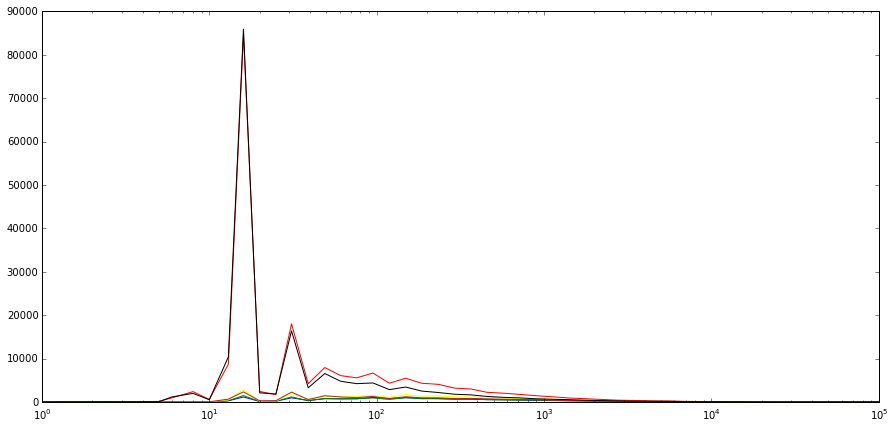

In [16]:
aggr_duration["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_duration["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_duration["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_duration["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_duration["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_duration["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

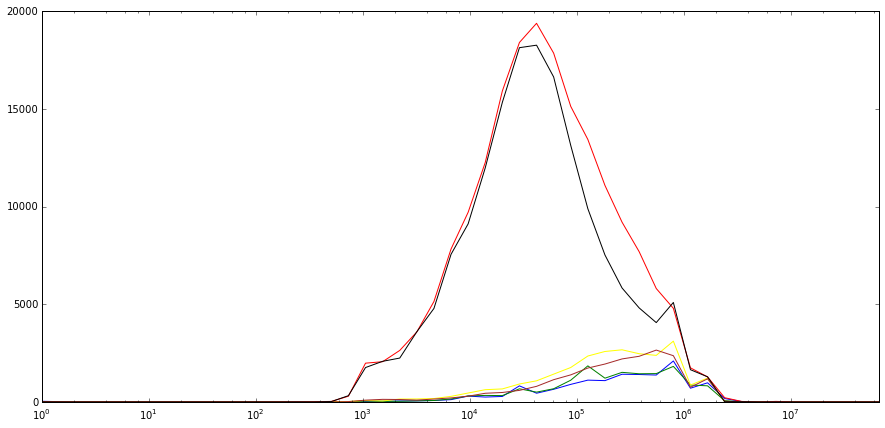

In [17]:
aggr_peak["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_peak["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_peak["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_peak["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_peak["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_peak["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

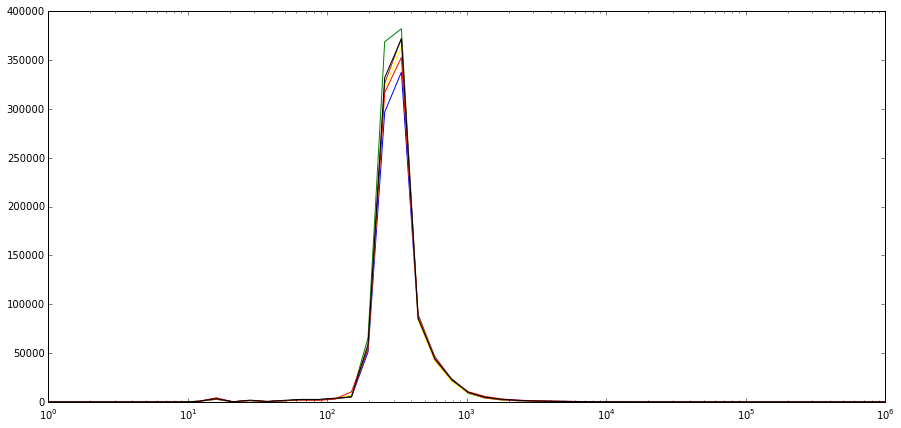

In [18]:
aggr_potential_duration["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_potential_duration["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_potential_duration["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_potential_duration["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_potential_duration["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_potential_duration["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

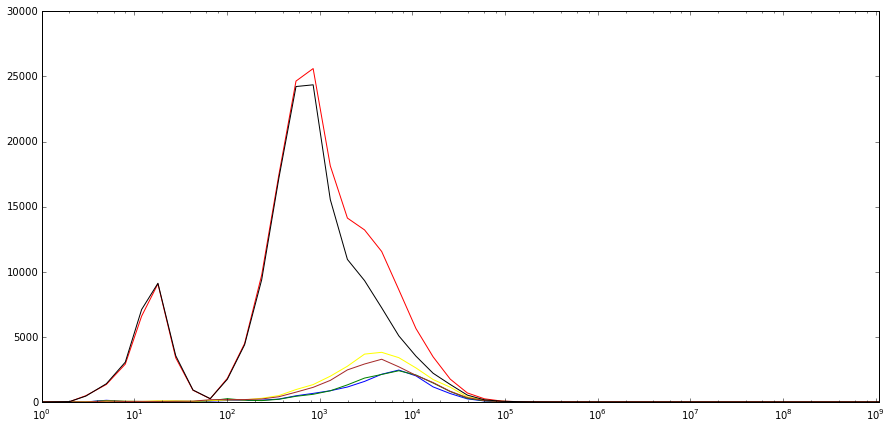

In [19]:
aggr_severity["control"].plot(kind="line", figsize=(15, 7), logx=True, color="blue")
aggr_severity["group2"].plot(kind="line", figsize=(15, 7), logx=True, color="green")
aggr_severity["group3"].plot(kind="line", figsize=(15, 7), logx=True, color="yellow")
aggr_severity["group4"].plot(kind="line", figsize=(15, 7), logx=True, color="red")
aggr_severity["group5"].plot(kind="line", figsize=(15, 7), logx=True, color="brown")
aggr_severity["group6"].plot(kind="line", figsize=(15, 7), logx=True, color="black")

Also check the number of checkerboard events that occurred:

In [29]:
labels = [x for x, y in hist_duration.items()]
counts = [sum(reduce(aggregate_arrays, y)) for x, y in hist_duration.items()]

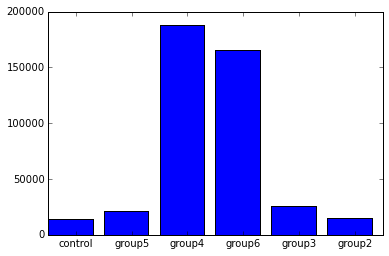

In [41]:
plt.bar(np.arange(len(labels)), counts)
unused = plt.xticks(np.arange(len(labels)) + 0.5, labels)

## OS breakdown

In [45]:
os_mac = valid.filter(lambda p: p["environment/system/os/name"] == "Darwin")
os_win = valid.filter(lambda p: p["environment/system/os/name"] == "Windows_NT")
os_nix = valid.filter(lambda p: p["environment/system/os/name"] == "Linux")

In [47]:
[os_mac.count(), os_win.count(), os_nix.count()]

[716, 37576, 615]